In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io

sns.set()
sns.set_style("white")

%matplotlib inline


## Original Organics formulation

In [2]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [3]:
U,V = np.linalg.eig(Wyy)

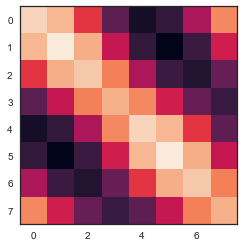

In [4]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [5]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [6]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

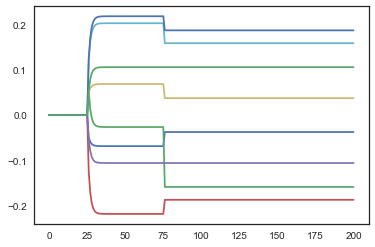

In [7]:
# Plot of Y traces!
plt.figure()
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [8]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

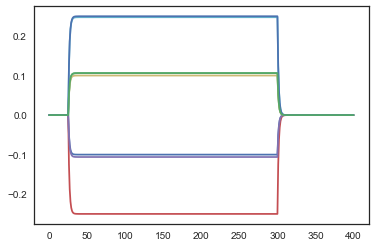

In [9]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [10]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def start_simulation(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    
    
    # Unpack variables
    I, u, v, y, sig = state_init
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u )) / tau * dt

        y += (-y + u - v) / 100 * dt

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        I_lst.append(I)
        sig_lst.append(sig)
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

### Updates from previous meeting

Changes from the previous meeting:

1. Moved threshold y0 to a z-neuron with $z = y - y_0$

2. Removed $I_{ref}$. Previous equation

3. 'Reseting' is implemented by an impulse given to $v$ at the start of the trial



### Description of the current model

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + I_p)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

and for $z$,

$$ \tau\frac{dz}{dt} = -z + y - y_0$$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 5$, for a duration of two time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $z$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $z$.
    
    In particular, $ \tau\frac{dI}{dt} = K(y-y_0)  $


The behavior of $I$ is different in these two different modes. To achieve this, we rely on the gating variables $a_I$, and require that

$$ \tau\frac{dI}{dt} = a_IK(y - y_0) $$


The gating $a_I$ itself can be modeled as a dynamic variable that is linked to the global state $s$.
$$ \frac{da_I}{dt} = \frac{1}{\tau_I}(-a_I + s) $$

The simulation is run below, each state lasts 100 ms.

In [11]:
def plot_simulation(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst, alpha=0.1)
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst, alpha=0.1)
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst, alpha=0.1)
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst, alpha=0.1)
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [12]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 5.0,
              'sigma': 0.0}

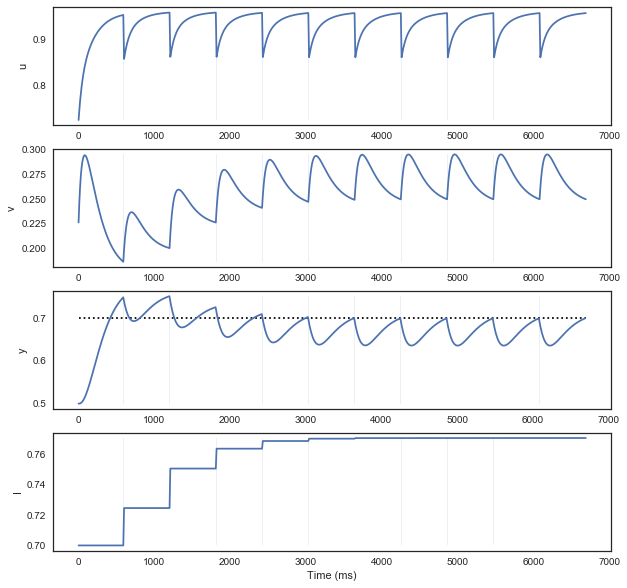

In [13]:
# Initial run
state_init = [0.7, 0.7, 0.2, 0.5, 0.0]
ulst, vlst, ylst, Ilst, siglst = start_simulation(state_init, PARAMS_DICT, 60)

# For subsequent runs, flip the state every 100 trials
for k in range(20):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 60)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
plot_simulation(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

## Adding noise to the simulation

Now we try to do the simulation in parallel, with multiple trials and noise

In [14]:
def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [15]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [16]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05}

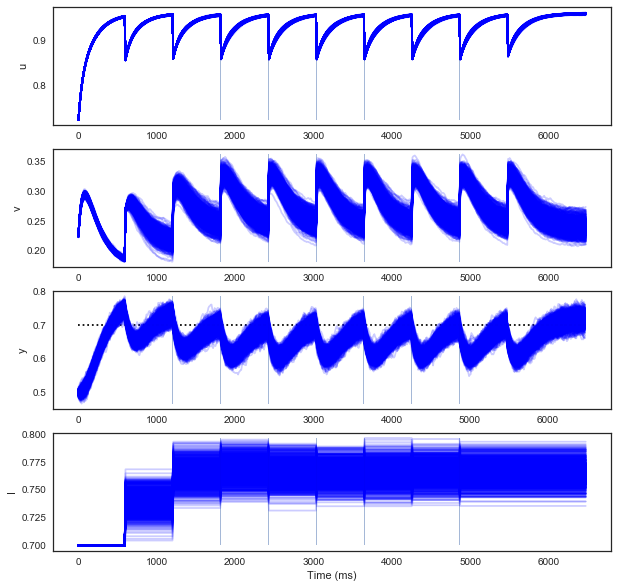

In [17]:
# Initial run
ntrials = 1000
duration = 600 #ms
nstages = 10
nbin = int(duration / PARAMS_DICT['dt'])


state_init = [np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.2,
              np.ones(ntrials) * 0.5,
              0.0]

ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)

# For subsequent runs, flip the state every 100 trials
for k in range((nstages - 2) * 2):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
    
# For the last run, produce the behavior when the threshold is reached
ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 100)

ulst += ulst2
vlst += vlst2
ylst += ylst2
Ilst += Ilst2
siglst += siglst2

plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Mean level at decision time is  0.687259420797
Mean decision time is  79.4933333333


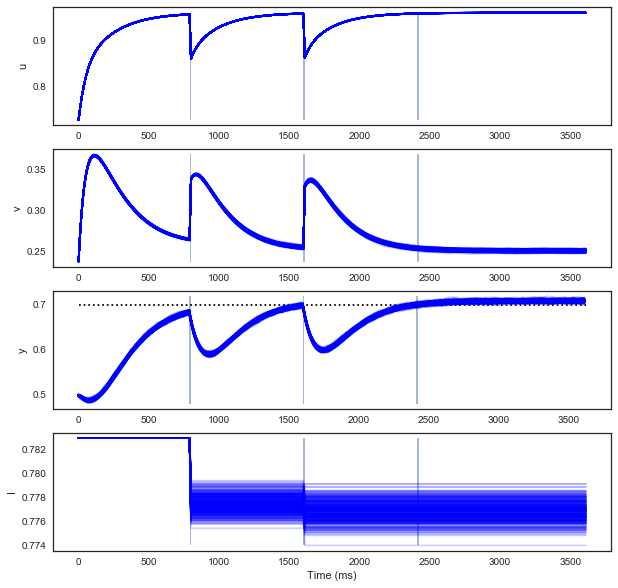

In [18]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=3, duration=800, sigma=0.01, K=3.3, initI=0.783)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2), 0.7)
times = times[(times > 0) & (times != np.inf)]
print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
scipy.io.savemat('PlotTools/uv_simulation_data101518.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT})

In [19]:
# initI = 0.766 for correct time in 600 ms

In [20]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, sigma=sigma, K=K, initI=0.778)
        times = get_times_lst_from_y(np.array(ylst2), 0.7)
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.210526315789
Working on K =  0.421052631579
Working on K =  0.631578947368
Working on K =  0.842105263158
Working on K =  1.05263157895
Working on K =  1.26315789474
Working on K =  1.47368421053
Working on K =  1.68421052632
Working on K =  1.89473684211
Working on K =  2.10526315789
Working on K =  2.31578947368
Working on K =  2.52631578947
Working on K =  2.73684210526
Working on K =  2.94736842105
Working on K =  3.15789473684
Working on K =  3.36842105263
Working on K =  3.57894736842
Working on K =  3.78947368421
Working on K =  4.0
Working on K =  0.0
Working on K =  0.210526315789
Working on K =  0.421052631579
Working on K =  0.631578947368
Working on K =  0.842105263158
Working on K =  1.05263157895
Working on K =  1.26315789474
Working on K =  1.47368421053
Working on K =  1.68421052632
Working on K =  1.89473684211
Working on K =  2.10526315789
Working on K =  2.31578947368
Working on K =  2.52631578947
Working on K =  2.73684210526
Wo

Text(0,0.5,'$\\sigma$')

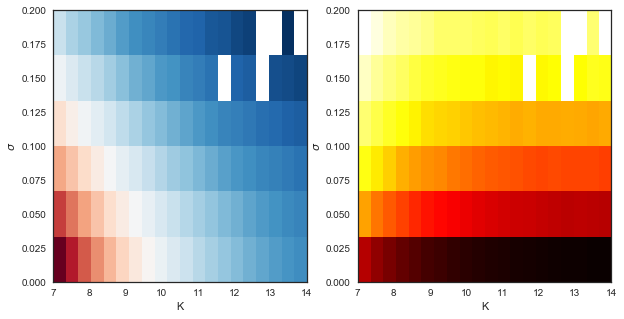

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

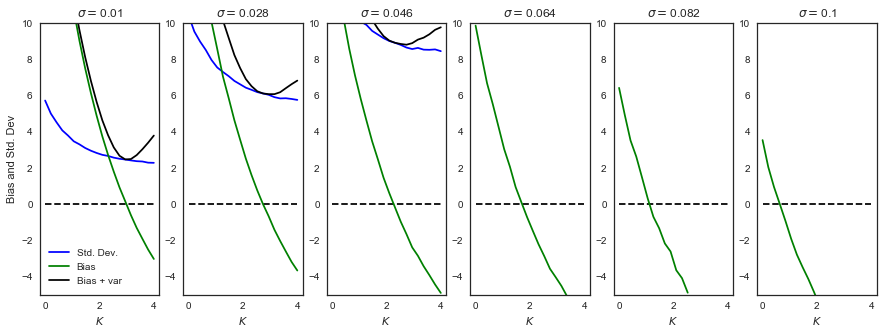

In [22]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

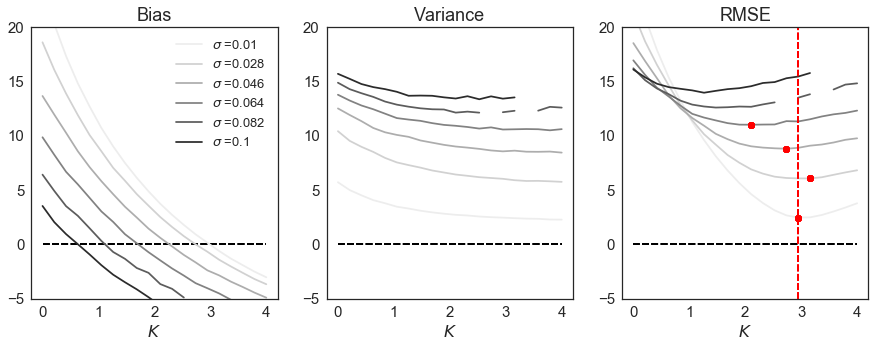

In [23]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

In [24]:
mselst = (meanlst - 60) ** 2 + varlst ** 2
mselst[np.isnan(mselst)] = np.inf
np.argmin(mselst, axis=1)

# TODO: simulate multiple times and take the average

array([14, 15, 13, 10,  7,  6], dtype=int64)

### Sampling from a prior

In [25]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, sigma=sigma, K=K, initI=0.778)
        times = get_times_lst_from_y(np.array(ylst2), 0.7)
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.210526315789
Working on K =  0.421052631579
Working on K =  0.631578947368
Working on K =  0.842105263158
Working on K =  1.05263157895
Working on K =  1.26315789474
Working on K =  1.47368421053
Working on K =  1.68421052632
Working on K =  1.89473684211
Working on K =  2.10526315789
Working on K =  2.31578947368
Working on K =  2.52631578947
Working on K =  2.73684210526
Working on K =  2.94736842105
Working on K =  3.15789473684
Working on K =  3.36842105263
Working on K =  3.57894736842
Working on K =  3.78947368421
Working on K =  4.0
Working on K =  0.0
Working on K =  0.210526315789
Working on K =  0.421052631579
Working on K =  0.631578947368
Working on K =  0.842105263158
Working on K =  1.05263157895
Working on K =  1.26315789474
Working on K =  1.47368421053
Working on K =  1.68421052632
Working on K =  1.89473684211
Working on K =  2.10526315789
Working on K =  2.31578947368
Working on K =  2.52631578947
Working on K =  2.73684210526
Wo

### Ready, Set, Go task

To simulate the Ready, Set, Go task, we first pick a parameter (arbitrarily within the set of parameters simulated above. We will pick $\sigma = 0.01, I_{init} = 0.77$.

From the graph above, the optimal value of $K$ for these parameters is $K \approx 1.9$. We can now simulate the RSG task below.

In [84]:
#KI optimization for subject SWE in RSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 12)

nK = 11
nI = 11
Klst = np.linspace(1, 3.5, nK)
initIlst = np.linspace(0.78, 0.79, nI)
MSELST2 = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, time in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=time, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2), 0.7)
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    MSELST2.append(mse_lst)
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
I =  0.78 K =  1.0 Total MSE =  48788300.0
I =  0.78 K =  1.25 Total MSE =  36323800.0
I =  0.78 K =  1.5 Total MSE =  27793200.0
I =  0.78 K =  1.75 Total MSE =  22271900.0
I =  0.78 K =  2.0 Total MSE =  18580200.0
I =  0.78 K =  2.25 Total MSE =  16128500.0
I =  0.78 K =  2.5 Total MSE =  15314300.0
I =  0.78 K =  2.75 Total MSE =  14435400.0
I =  0.78 K =  3.0 Total MSE =  14544300.0
I =  0.78 K =  3.25 Total MSE =  14732900.0
I =  0.78 K =  3.5 Total MSE =  15496900.0
I =  0.781 K =  1.0 Total MSE =  62955000.0
I =  0.781 K =  1.25 Total MSE =  44935400.0
I =  0.781 K =  1.5 Total MSE =  32161200.0
I =  0.781 K =  1.75 Total MSE =  23782600.0
I =  0.781 K =  2.0 Total MSE =  18135500.0
I =  0.781 K =  2.25 Total MSE =  14418100.0
I =  0.781 K =  2.5 Total MSE =  11992400.0
I =  0.781 K =  2.75 Total MSE =  11576300.0
I =  0.781 K =  3.0 Total MSE =  10677800.0
I =  0.781 K =  3.25 Total MSE =  11330200.0
I =  0.781 K =  3.5 Total MSE =  12036700.0
I =  0.78

I =  0.785 K =  2.75 Total MSE =  45074000.0
I =  0.785 K =  3.0 Total MSE =  35316700.0
I =  0.785 K =  3.25 Total MSE =  31152500.0
I =  0.785 K =  3.5 Total MSE =  29504800.0
I =  0.786 K =  1.0 Total MSE =  549165800.0
I =  0.786 K =  1.25 Total MSE =  380861400.0
I =  0.786 K =  1.5 Total MSE =  272998700.0
I =  0.786 K =  1.75 Total MSE =  196370300.0
I =  0.786 K =  2.0 Total MSE =  141729200.0
I =  0.786 K =  2.25 Total MSE =  101992800.0
I =  0.786 K =  2.5 Total MSE =  74023400.0
I =  0.786 K =  2.75 Total MSE =  59885400.0
I =  0.786 K =  3.0 Total MSE =  44594600.0
I =  0.786 K =  3.25 Total MSE =  39862500.0
I =  0.786 K =  3.5 Total MSE =  32593900.0
I =  0.787 K =  1.0 Total MSE =  814736900.0
I =  0.787 K =  1.25 Total MSE =  564318100.0
I =  0.787 K =  1.5 Total MSE =  403668900.0
I =  0.787 K =  1.75 Total MSE =  274971700.0
I =  0.787 K =  2.0 Total MSE =  209561300.0
I =  0.787 K =  2.25 Total MSE =  148808400.0
I =  0.787 K =  2.5 Total MSE =  106446300.0
I =  0.78

I =  0.78 K =  1.5 Total MSE =  78218600.0
I =  0.78 K =  1.75 Total MSE =  74645600.0
I =  0.78 K =  2.0 Total MSE =  69972300.0
I =  0.78 K =  2.25 Total MSE =  68119200.0
I =  0.78 K =  2.5 Total MSE =  68782200.0
I =  0.78 K =  2.75 Total MSE =  72384700.0
I =  0.78 K =  3.0 Total MSE =  73014000.0
I =  0.78 K =  3.25 Total MSE =  68728700.0
I =  0.78 K =  3.5 Total MSE =  75805900.0
I =  0.781 K =  1.0 Total MSE =  97502100.0
I =  0.781 K =  1.25 Total MSE =  83970300.0
I =  0.781 K =  1.5 Total MSE =  76477600.0
I =  0.781 K =  1.75 Total MSE =  70975400.0
I =  0.781 K =  2.0 Total MSE =  69296100.0
I =  0.781 K =  2.25 Total MSE =  64663300.0
I =  0.781 K =  2.5 Total MSE =  70133800.0
I =  0.781 K =  2.75 Total MSE =  68715700.0
I =  0.781 K =  3.0 Total MSE =  66412700.0
I =  0.781 K =  3.25 Total MSE =  70922500.0
I =  0.781 K =  3.5 Total MSE =  68081200.0
I =  0.782 K =  1.0 Total MSE =  108766500.0
I =  0.782 K =  1.25 Total MSE =  94828700.0
I =  0.782 K =  1.5 Total MSE 

I =  0.785 K =  3.5 Total MSE =  88296900.0
I =  0.786 K =  1.0 Total MSE =  252320300.0
I =  0.786 K =  1.25 Total MSE =  195166800.0
I =  0.786 K =  1.5 Total MSE =  169316200.0
I =  0.786 K =  1.75 Total MSE =  128327400.0
I =  0.786 K =  2.0 Total MSE =  118543000.0
I =  0.786 K =  2.25 Total MSE =  110640200.0
I =  0.786 K =  2.5 Total MSE =  96143700.0
I =  0.786 K =  2.75 Total MSE =  92552800.0
I =  0.786 K =  3.0 Total MSE =  85939700.0
I =  0.786 K =  3.25 Total MSE =  89066100.0
I =  0.786 K =  3.5 Total MSE =  84010400.0
I =  0.787 K =  1.0 Total MSE =  331771400.0
I =  0.787 K =  1.25 Total MSE =  256564100.0
I =  0.787 K =  1.5 Total MSE =  202046000.0
I =  0.787 K =  1.75 Total MSE =  154191400.0
I =  0.787 K =  2.0 Total MSE =  134885700.0
I =  0.787 K =  2.25 Total MSE =  109564400.0
I =  0.787 K =  2.5 Total MSE =  105052000.0
I =  0.787 K =  2.75 Total MSE =  104227600.0
I =  0.787 K =  3.0 Total MSE =  91639700.0
I =  0.787 K =  3.25 Total MSE =  93715300.0
I =  0.7

I =  0.78 K =  2.0 Total MSE =  133020200.0
I =  0.78 K =  2.25 Total MSE =  128762400.0
I =  0.78 K =  2.5 Total MSE =  132758600.0
I =  0.78 K =  2.75 Total MSE =  133660800.0
I =  0.78 K =  3.0 Total MSE =  135466000.0
I =  0.78 K =  3.25 Total MSE =  137313200.0
I =  0.78 K =  3.5 Total MSE =  142062100.0
I =  0.781 K =  1.0 Total MSE =  135287100.0
I =  0.781 K =  1.25 Total MSE =  130472400.0
I =  0.781 K =  1.5 Total MSE =  125950500.0
I =  0.781 K =  1.75 Total MSE =  123586000.0
I =  0.781 K =  2.0 Total MSE =  128401700.0
I =  0.781 K =  2.25 Total MSE =  125157700.0
I =  0.781 K =  2.5 Total MSE =  126278600.0
I =  0.781 K =  2.75 Total MSE =  129756400.0
I =  0.781 K =  3.0 Total MSE =  132377400.0
I =  0.781 K =  3.25 Total MSE =  135694800.0
I =  0.781 K =  3.5 Total MSE =  143503400.0
I =  0.782 K =  1.0 Total MSE =  140292600.0
I =  0.782 K =  1.25 Total MSE =  129751900.0
I =  0.782 K =  1.5 Total MSE =  127018700.0
I =  0.782 K =  1.75 Total MSE =  123119200.0
I =  0.

I =  0.785 K =  3.25 Total MSE =  155192400.0
I =  0.785 K =  3.5 Total MSE =  153805400.0
I =  0.786 K =  1.0 Total MSE =  203441300.0
I =  0.786 K =  1.25 Total MSE =  181452200.0
I =  0.786 K =  1.5 Total MSE =  159590400.0
I =  0.786 K =  1.75 Total MSE =  146760900.0
I =  0.786 K =  2.0 Total MSE =  149156100.0
I =  0.786 K =  2.25 Total MSE =  137999300.0
I =  0.786 K =  2.5 Total MSE =  132359600.0
I =  0.786 K =  2.75 Total MSE =  146232000.0
I =  0.786 K =  3.0 Total MSE =  145944600.0
I =  0.786 K =  3.25 Total MSE =  152770900.0
I =  0.786 K =  3.5 Total MSE =  152516500.0
I =  0.787 K =  1.0 Total MSE =  234862900.0
I =  0.787 K =  1.25 Total MSE =  202005000.0
I =  0.787 K =  1.5 Total MSE =  171337100.0
I =  0.787 K =  1.75 Total MSE =  157588200.0
I =  0.787 K =  2.0 Total MSE =  150225700.0
I =  0.787 K =  2.25 Total MSE =  142731400.0
I =  0.787 K =  2.5 Total MSE =  144578600.0
I =  0.787 K =  2.75 Total MSE =  143759100.0
I =  0.787 K =  3.0 Total MSE =  144736200.0


I =  0.78 K =  1.5 Total MSE =  182607900.0
I =  0.78 K =  1.75 Total MSE =  188513500.0
I =  0.78 K =  2.0 Total MSE =  190124200.0
I =  0.78 K =  2.25 Total MSE =  189119600.0
I =  0.78 K =  2.5 Total MSE =  197395600.0
I =  0.78 K =  2.75 Total MSE =  194635500.0
I =  0.78 K =  3.0 Total MSE =  201512000.0
I =  0.78 K =  3.25 Total MSE =  212216200.0
I =  0.78 K =  3.5 Total MSE =  215859700.0
I =  0.781 K =  1.0 Total MSE =  181485900.0
I =  0.781 K =  1.25 Total MSE =  182101700.0
I =  0.781 K =  1.5 Total MSE =  186889800.0
I =  0.781 K =  1.75 Total MSE =  179436800.0
I =  0.781 K =  2.0 Total MSE =  184250000.0
I =  0.781 K =  2.25 Total MSE =  184796300.0
I =  0.781 K =  2.5 Total MSE =  189894000.0
I =  0.781 K =  2.75 Total MSE =  191685500.0
I =  0.781 K =  3.0 Total MSE =  196705400.0
I =  0.781 K =  3.25 Total MSE =  197391900.0
I =  0.781 K =  3.5 Total MSE =  206944000.0
I =  0.782 K =  1.0 Total MSE =  187883200.0
I =  0.782 K =  1.25 Total MSE =  176064500.0
I =  0.78

I =  0.785 K =  2.75 Total MSE =  196539400.0
I =  0.785 K =  3.0 Total MSE =  200146000.0
I =  0.785 K =  3.25 Total MSE =  204898300.0
I =  0.785 K =  3.5 Total MSE =  215107700.0
I =  0.786 K =  1.0 Total MSE =  215137100.0
I =  0.786 K =  1.25 Total MSE =  196554300.0
I =  0.786 K =  1.5 Total MSE =  193009600.0
I =  0.786 K =  1.75 Total MSE =  185569600.0
I =  0.786 K =  2.0 Total MSE =  197430900.0
I =  0.786 K =  2.25 Total MSE =  184264400.0
I =  0.786 K =  2.5 Total MSE =  194521200.0
I =  0.786 K =  2.75 Total MSE =  201915100.0
I =  0.786 K =  3.0 Total MSE =  196567900.0
I =  0.786 K =  3.25 Total MSE =  209922000.0
I =  0.786 K =  3.5 Total MSE =  209298600.0
I =  0.787 K =  1.0 Total MSE =  218835300.0
I =  0.787 K =  1.25 Total MSE =  202228600.0
I =  0.787 K =  1.5 Total MSE =  199980100.0
I =  0.787 K =  1.75 Total MSE =  191700900.0
I =  0.787 K =  2.0 Total MSE =  186773400.0
I =  0.787 K =  2.25 Total MSE =  188014800.0
I =  0.787 K =  2.5 Total MSE =  187205800.0


In [90]:
# Doing random sampling for (I,K)

#KI optimization for subject SWE in RSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 12)

nsamples = 100
Klst = np.random.uniform(low=1, high=3.5, size=nsamples)
initIlst = np.random.uniform(low=0.78, high=0.79, size=nsamples)
MSELST2 = []
ILST = []
KLST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros(nsamples)
    for i in range(nsamples):
        I = initIlst[i]
        K = Klst[i]
        mse_total = 0
        for k, time in enumerate(durations):
            #print('Doing time #', i, '=', time)

            ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                   duration=time, sigma=sigma, K=K, initI=I)

            Ylst2 = np.array(ylst2)
            times = get_times_lst_from_y(np.array(Ylst2), 0.7)
            times = times[(times > 0) & (times != np.inf)]

            mse_total += np.sum((times * 10 - time)**2)

        mse_lst[i] = mse_total
        print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    MSELST2.append(mse_lst)
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
I =  0.786634421777 K =  1.18386230244 Total MSE =  866930200.0
I =  0.786187148164 K =  2.53136398982 Total MSE =  92032100.0
I =  0.780966797992 K =  1.18080790736 Total MSE =  48764000.0
I =  0.780211805222 K =  3.44838701952 Total MSE =  14528900.0
I =  0.789286755365 K =  3.31472976602 Total MSE =  105027800.0
I =  0.787097609073 K =  1.77174294469 Total MSE =  494258800.0
I =  0.784585939343 K =  1.24278433158 Total MSE =  266533400.0
I =  0.788291451181 K =  3.24365525457 Total MSE =  73965000.0
I =  0.783586330925 K =  1.56171296618 Total MSE =  90684800.0
I =  0.780519787994 K =  2.12472047897 Total MSE =  16060600.0
I =  0.7895161294 K =  1.50029837961 Total MSE =  788333200.0
I =  0.78670698283 K =  1.02539863385 Total MSE =  1047854200.0
I =  0.786015545161 K =  1.96538016704 Total MSE =  193176800.0
I =  0.789081473685 K =  1.66598025312 Total MSE =  765046800.0
I =  0.782458778821 K =  2.84783660611 Total MSE =  10363400.0
I =  0.785567376803 K =  

I =  0.781808238289 K =  2.4558833836 Total MSE =  29201900.0
I =  0.781485999733 K =  2.71944008602 Total MSE =  26600800.0
I =  0.782003061932 K =  2.04526721321 Total MSE =  34255500.0
I =  0.78591658579 K =  2.02159219059 Total MSE =  130688000.0
I =  0.787296102051 K =  1.5318198787 Total MSE =  433042700.0
I =  0.780148127167 K =  1.77868392631 Total MSE =  36595900.0
I =  0.788279195643 K =  1.38842514647 Total MSE =  726275800.0
I =  0.780712603165 K =  3.1506915963 Total MSE =  29563700.0
I =  0.781973219792 K =  3.13721321275 Total MSE =  25809600.0
I =  0.789579677208 K =  2.98696830664 Total MSE =  133094100.0
I =  0.780672619918 K =  1.05267197009 Total MSE =  65828200.0
I =  0.788853792175 K =  3.46754592725 Total MSE =  60211600.0
I =  0.788979304099 K =  1.76457402029 Total MSE =  537939900.0
I =  0.788881555593 K =  2.05540108734 Total MSE =  361884000.0
I =  0.786997847666 K =  1.43659265599 Total MSE =  450211300.0
I =  0.784344212311 K =  2.51639490875 Total MSE =  

I =  0.783468262782 K =  2.3560675492 Total MSE =  55101900.0
I =  0.786385931359 K =  2.78540504714 Total MSE =  69615900.0
I =  0.789784695221 K =  3.27225249917 Total MSE =  92310700.0
I =  0.783211397795 K =  2.7493533128 Total MSE =  46887700.0
I =  0.78101799024 K =  3.37789494136 Total MSE =  49183500.0
I =  0.788179086633 K =  2.36512833542 Total MSE =  157810700.0
I =  0.783006140703 K =  1.53342381969 Total MSE =  84287600.0
I =  0.782760569943 K =  2.02227088364 Total MSE =  57031900.0
I =  0.788963417204 K =  2.60378800158 Total MSE =  145265800.0
I =  0.781904970047 K =  1.63988077285 Total MSE =  60885400.0
I =  0.781781259828 K =  2.61850498632 Total MSE =  45255100.0
I =  0.785571623975 K =  3.39994639976 Total MSE =  49196400.0
I =  0.785698112906 K =  1.67319447901 Total MSE =  151521000.0
I =  0.783666198504 K =  1.01568574785 Total MSE =  161486400.0
I =  0.786302688545 K =  2.25375687017 Total MSE =  98217300.0
I =  0.782403830733 K =  1.31015859446 Total MSE =  85

I =  0.784485222962 K =  1.22796931043 Total MSE =  162589800.0
I =  0.785113954784 K =  1.4678649769 Total MSE =  142577700.0
I =  0.78194611541 K =  2.91531542369 Total MSE =  63637400.0
I =  0.787096166701 K =  1.85262578616 Total MSE =  165556200.0
I =  0.784561708853 K =  2.61725232489 Total MSE =  72114000.0
I =  0.780413461379 K =  3.49850410423 Total MSE =  73946100.0
I =  0.788822267747 K =  1.32097310177 Total MSE =  453125400.0
I =  0.787667119223 K =  3.28474079415 Total MSE =  84085100.0
I =  0.786806219231 K =  2.6495305393 Total MSE =  86273700.0
I =  0.780938772597 K =  2.27019122183 Total MSE =  68524100.0
I =  0.787005701203 K =  2.34075266334 Total MSE =  108203900.0
*** sigma =  0.025  ***
I =  0.786634421777 K =  1.18386230244 Total MSE =  250316400.0
I =  0.786187148164 K =  2.53136398982 Total MSE =  94996100.0
I =  0.780966797992 K =  1.18080790736 Total MSE =  100645000.0
I =  0.780211805222 K =  3.44838701952 Total MSE =  94487000.0
I =  0.789286755365 K =  3.

I =  0.789706567774 K =  2.20596358579 Total MSE =  171842600.0
I =  0.788451037638 K =  3.44976987588 Total MSE =  111169600.0
I =  0.789163282867 K =  2.33292791833 Total MSE =  157552000.0
I =  0.78658565229 K =  2.13597650167 Total MSE =  128946500.0
I =  0.787150047534 K =  2.81112431645 Total MSE =  113301500.0
I =  0.781450490346 K =  3.4376015385 Total MSE =  113153600.0
I =  0.788520005745 K =  3.06232921575 Total MSE =  114645400.0
I =  0.786030045999 K =  1.54900645758 Total MSE =  154841800.0
I =  0.782590632877 K =  2.69244245439 Total MSE =  106470300.0
I =  0.788925287074 K =  2.84677677704 Total MSE =  118910800.0
I =  0.785888115557 K =  2.55255032263 Total MSE =  107280300.0
I =  0.781808238289 K =  2.4558833836 Total MSE =  101047600.0
I =  0.781485999733 K =  2.71944008602 Total MSE =  108494100.0
I =  0.782003061932 K =  2.04526721321 Total MSE =  108245500.0
I =  0.78591658579 K =  2.02159219059 Total MSE =  117756100.0
I =  0.787296102051 K =  1.5318198787 Total 

I =  0.780365326995 K =  3.40814438379 Total MSE =  140489900.0
I =  0.782057394321 K =  1.91142331194 Total MSE =  124054900.0
I =  0.781803453645 K =  2.60316048406 Total MSE =  126634700.0
I =  0.780995260994 K =  1.6734071615 Total MSE =  125869700.0
I =  0.782823440034 K =  2.91747338573 Total MSE =  126608800.0
I =  0.78853955419 K =  2.75476124274 Total MSE =  134923100.0
I =  0.787149587675 K =  1.32261955289 Total MSE =  204880400.0
I =  0.789160778506 K =  2.82290627139 Total MSE =  136438200.0
I =  0.787889584615 K =  1.5678901622 Total MSE =  189366100.0
I =  0.788781788196 K =  1.6301051686 Total MSE =  201229300.0
I =  0.787804041249 K =  2.67039855039 Total MSE =  133922200.0
I =  0.781490712655 K =  2.91724852294 Total MSE =  129901000.0
I =  0.783468262782 K =  2.3560675492 Total MSE =  121381000.0
I =  0.786385931359 K =  2.78540504714 Total MSE =  129682300.0
I =  0.789784695221 K =  3.27225249917 Total MSE =  132936600.0
I =  0.783211397795 K =  2.7493533128 Total M

I =  0.783191382763 K =  3.41866023608 Total MSE =  157908700.0
I =  0.788869756641 K =  2.14028597661 Total MSE =  158874100.0
I =  0.785188794783 K =  2.1058496724 Total MSE =  144748600.0
I =  0.787862848099 K =  1.08085765485 Total MSE =  249136700.0
I =  0.783301219428 K =  2.04504732013 Total MSE =  136220000.0
I =  0.782326890811 K =  2.85865399012 Total MSE =  144894800.0
I =  0.780203537327 K =  2.91726466915 Total MSE =  155863900.0
I =  0.785638194495 K =  1.71029322039 Total MSE =  148386900.0
I =  0.786728796997 K =  2.71598435229 Total MSE =  136912700.0
I =  0.785419286465 K =  1.91075401531 Total MSE =  144462500.0
I =  0.788949489353 K =  1.62470967243 Total MSE =  204310100.0
I =  0.78462249213 K =  2.98497742303 Total MSE =  142712600.0
I =  0.780793824846 K =  1.85324937664 Total MSE =  145785800.0
I =  0.784485222962 K =  1.22796931043 Total MSE =  155034900.0
I =  0.785113954784 K =  1.4678649769 Total MSE =  156978200.0
I =  0.78194611541 K =  2.91531542369 Total

I =  0.789286755365 K =  3.31472976602 Total MSE =  182850400.0
I =  0.787097609073 K =  1.77174294469 Total MSE =  185430300.0
I =  0.784585939343 K =  1.24278433158 Total MSE =  172854700.0
I =  0.788291451181 K =  3.24365525457 Total MSE =  187077600.0
I =  0.783586330925 K =  1.56171296618 Total MSE =  173187300.0
I =  0.780519787994 K =  2.12472047897 Total MSE =  187720000.0
I =  0.7895161294 K =  1.50029837961 Total MSE =  220175900.0
I =  0.78670698283 K =  1.02539863385 Total MSE =  212056400.0
I =  0.786015545161 K =  1.96538016704 Total MSE =  178962900.0
I =  0.789081473685 K =  1.66598025312 Total MSE =  201914300.0
I =  0.782458778821 K =  2.84783660611 Total MSE =  189822300.0
I =  0.785567376803 K =  1.91287893575 Total MSE =  171314900.0
I =  0.786303039251 K =  3.00567851022 Total MSE =  183195900.0
I =  0.783018892856 K =  2.00733468505 Total MSE =  170086600.0
I =  0.789706567774 K =  2.20596358579 Total MSE =  173536000.0
I =  0.788451037638 K =  3.44976987588 Tota

I =  0.787296102051 K =  1.5318198787 Total MSE =  201939600.0
I =  0.780148127167 K =  1.77868392631 Total MSE =  207998600.0
I =  0.788279195643 K =  1.38842514647 Total MSE =  213090400.0
I =  0.780712603165 K =  3.1506915963 Total MSE =  222955300.0
I =  0.781973219792 K =  3.13721321275 Total MSE =  221331800.0
I =  0.789579677208 K =  2.98696830664 Total MSE =  200974700.0
I =  0.780672619918 K =  1.05267197009 Total MSE =  203887900.0
I =  0.788853792175 K =  3.46754592725 Total MSE =  215465600.0
I =  0.788979304099 K =  1.76457402029 Total MSE =  202059300.0
I =  0.788881555593 K =  2.05540108734 Total MSE =  195460200.0
I =  0.786997847666 K =  1.43659265599 Total MSE =  201124800.0
I =  0.784344212311 K =  2.51639490875 Total MSE =  194080600.0
I =  0.785248363063 K =  3.06653239226 Total MSE =  205580200.0
I =  0.786369744364 K =  1.40642352275 Total MSE =  195781000.0
I =  0.780365326995 K =  3.40814438379 Total MSE =  227674400.0
I =  0.782057394321 K =  1.91142331194 Tot

I =  0.783211397795 K =  2.7493533128 Total MSE =  224756500.0
I =  0.78101799024 K =  3.37789494136 Total MSE =  249256700.0
I =  0.788179086633 K =  2.36512833542 Total MSE =  204191000.0
I =  0.783006140703 K =  1.53342381969 Total MSE =  214644000.0
I =  0.782760569943 K =  2.02227088364 Total MSE =  214293800.0
I =  0.788963417204 K =  2.60378800158 Total MSE =  214574900.0
I =  0.781904970047 K =  1.63988077285 Total MSE =  211783000.0
I =  0.781781259828 K =  2.61850498632 Total MSE =  233473100.0
I =  0.785571623975 K =  3.39994639976 Total MSE =  232696500.0
I =  0.785698112906 K =  1.67319447901 Total MSE =  203137400.0
I =  0.783666198504 K =  1.01568574785 Total MSE =  211431700.0
I =  0.786302688545 K =  2.25375687017 Total MSE =  203757700.0
I =  0.782403830733 K =  1.31015859446 Total MSE =  201724900.0
I =  0.7842595116 K =  2.79862365465 Total MSE =  223249100.0
I =  0.783191382763 K =  3.41866023608 Total MSE =  240411100.0
I =  0.788869756641 K =  2.14028597661 Total

In [91]:
# Sort the mse list
sorted_all = []
argsorted_all = []
for lst in MSELST2:
    sorted_all.append(np.sort(lst))
    argsorted_all.append(np.argsort(lst))

In [92]:
np.min(Klst)

1.0156857478473313

C:\Users\Le\Anaconda3b\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


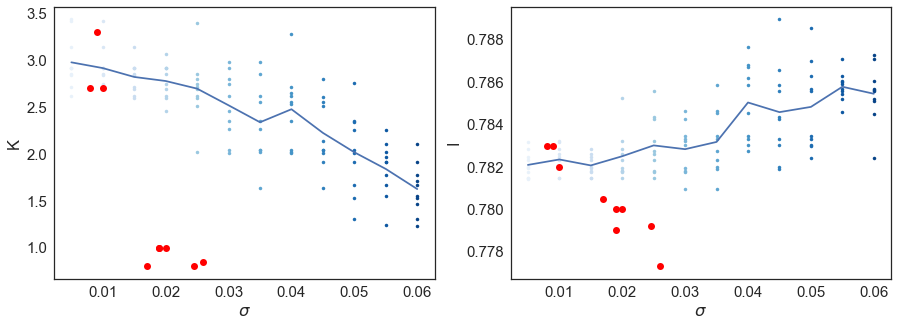

In [98]:
palette = sns.color_palette('Blues', len(MSELST2))
plt.figure(figsize=(15, 5))
Imeans = []
Kmeans = []
for i in range(len(MSELST2)):
    Ksorted = Klst[argsorted_all[i][:10]]
    Isorted = initIlst[argsorted_all[i][:10]]
    Imeans.append(np.mean(Isorted))
    Kmeans.append(np.mean(Ksorted))
    plt.subplot('121')
    plt.plot(np.ones(len(Ksorted)) * sigma_lst[i], Ksorted , '.', color=palette[i])
    plt.xlabel(r'$\sigma$')
    plt.ylabel('K')
    plt.subplot('122')
    plt.xlabel(r'$\sigma$')
    plt.ylabel('I')
    plt.plot(np.ones(len(Ksorted)) * sigma_lst[i], Isorted, '.', color=palette[i])

plt.subplot('121')
plt.plot(sigma_lst, Kmeans)
plt.subplot('122')
plt.plot(sigma_lst, Imeans)

# Behavioral results
sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];
plt.subplot('121')
plt.plot(sigma_behavior, K_behavior, 'or')
plt.subplot('122')
plt.plot(sigma_behavior, I_behavior, 'or')
    

In [ ]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



In [ ]:
Isim2 = []
Ksim2 = []
for id in range(12):
    I,K = find_min_IK(MSELST2[id], initIlst, Klst)
    Isim2.append(I)
    Ksim2.append(K)
    print(I, K)

In [ ]:
Isim = []
Ksim = []
for id in range(12):
    I,K = find_min_IK(MSELST[id], initIlst, Klst)
    Isim.append(I)
    Ksim.append(K)
    print(I, K)

In [ ]:
# Simulation results

# Behavioral results
sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

#plt.plot(sigma_lst, I)
plt.figure(figsize=(15, 5))
plt.subplot('121')
plt.plot(sigma_lst[:6], Ksim2[:6], '.', label='Simulation')
plt.plot(sigma_behavior, K_behavior, '.', label='Observed')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')
plt.legend(loc='lower left')

plt.subplot('122')
plt.plot(sigma_lst[:6], Isim2[:6], '.')
plt.plot(sigma_behavior, I_behavior, '.')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I$')



In [ ]:
0.778/0.784

In [ ]:
find_min_IK(MSELST[1], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[2], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[3], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[5], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[0], initIlst, Klst)

In [ ]:
find_min_indices(MSELST[0])

In [ ]:
np.argmin(MSELST[1])

In [ ]:
x = np.random.rand(6, 8)

In [ ]:
np.argmin(x)

In [ ]:
np.min(x)

In [ ]:
x[5][4]

In [ ]:
mse_lst[7][5]

In [ ]:
np.argmin(mse_lst)

In [ ]:
initIlst[7]

In [ ]:
plt.plot(Klst, mse_lst[7,:])

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.flipud(np.log(mse_lst)), cmap='hot', aspect='auto',
           extent=[np.min(Klst), np.max(Klst), np.min(initIlst), np.max(initIlst)])
plt.xlabel(r'$K$')
plt.ylabel(r'$I_{init}$')
plt.colorbar(label='log MSE')
plt.savefig('SWE_KI_optimization.pdf')

In [ ]:
#KI optimization for subject SWE in RSSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(600, 1000, 11)

prod_time_lst = []
prod_var_lst = []

mse_lst = np.zeros((11, 11))
Klst = np.linspace(2.5, 3.5, 11)
initIlst = np.linspace(0.775, 0.785, 11)

for i, I in enumerate(initIlst):
    for j, K in enumerate(Klst):
        #print('I = ', I, 'K = ', K)
        mse_total = 0
        for k, time in enumerate(durations):
            #print('Doing time #', i, '=', time)

            ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, 
                                                                   duration=time, sigma=0.01, K=K, initI=I)

            Ylst2 = np.array(ylst2)
            times = get_times_lst_from_y(np.array(Ylst2), 0.7)
            times = times[(times > 0) & (times != np.inf)]

            mse_total += np.sum((times * 10 - time)**2)

        mse_lst[i][j] = mse_total
        print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    
plt.plot(initIlst, mse_lst)

In [ ]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(500, 700, 11)

prod_time_lst = []
prod_var_lst = []

for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                           duration=time, sigma=0.01, K=1.8, initI=0.77)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('Production times in RSG simulation')

In [ ]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = 'VR_EKF_ObsAct0_20171105.mat'

sigma_val = 0.026
I_val = 0.7773
K_val = 0.85

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

In [ ]:
# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('
                           
                           
                           ')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])



# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, sigma=0.01, K=3, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, sigma=0.01, K=2.9, initI=0.7818)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

In [ ]:
# Fitting the data to find sigma

# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('SWE_EKF_ObsAct0_20171125.mat')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=3, duration=time, sigma=0.01, K=3, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=4, duration=time, sigma=0.01, K=2.9, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

### Scalar variability

In [ ]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
sigmas = np.linspace(0.01, 0.2, 6)
durations = np.linspace(400, 1000, 10)

prod_time_lst = np.zeros((6, 10))
prod_var_lst = np.zeros((6, 10))

for i, sigma in enumerate(sigmas):
    print('Doing sigma #', i, '=', sigma)
    for j, duration in enumerate(durations):
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=duration, sigma=sigma, K=1.89, initI=0.771)

        Ylst2 = np.array(ylst2)
        times = get_times_lst_from_y(np.array(Ylst2), 0.7)
        times = times[(times > 0) & (times != np.inf)]

        prod_time_lst[i][j] = np.mean(times)
        prod_var_lst[i][j] = np.std(times)
    

In [ ]:
colors = sns.color_palette('hls', 6)

# Plot the result
for i in range(6):
    meanlst = prod_time_lst[i,:] * 10
    varlst = prod_var_lst[i,:]

    meanmean = np.mean(meanlst)
    varmean = np.mean(varlst)
    
    plotx = np.linspace(0, meanmean * 1.2, 10)

    # Do linear regression
    m, c,_,_,_ = scipy.stats.linregress(meanlst, varlst)

    plt.plot(meanlst, varlst, '.', label=r'$\sigma = $' + str(sigmas[i])[:4], color=colors[i])
    plt.plot(plotx, plotx * varmean / meanmean, '--', color=colors[i], linewidth=1.5)
    #plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)

plt.xlabel('$t_P$ (ms)')
plt.ylabel('standard dev $(t_P)$  (ms)')
plt.title('Production times in RSG simulation')
    

#plt.xlim((0, 80))
#plt.ylim((0, 23))
plt.legend(loc='upper left')

### Multiple productions

Now we simulate $S^a G^b$ where there are $a$ cues for entrainment and $b$ cues for production. Cases for $b=1$ have been simulated above.

We do $a=2$ and $b=1,2,3,...$.

In [ ]:
def simulate_trial_multiple(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7, nprod=5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        print(state_init[4])

    if nstages > 1:
        # For the last run, produce the behavior when the threshold is reached
        #state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
        #ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
        #ulst += ulst2
        #lst += vlst2
        #ylst += ylst2
        #Ilst += Ilst2
        #siglst += siglst2
        
        # Gather the last state before nan is reached
        for k in range(nprod):
            state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2
            
            state_init = get_last_valid_arrs([Ilst, ulst, vlst, ylst]) + [1.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2

            
        
        
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

In [ ]:
def get_last_valid(lst):
    '''Get the last state of lst before nan'''
    return lst[~np.isnan(lst)][-1]

def get_last_valid_arr(arr):
    '''Get the last state of arr for each run'''
    Arr = np.array(arr)
    states = []
    for i in range(Arr.shape[1]):
        lst = Arr[:,i]
        states.append(get_last_valid(lst))
        #print(get_last_valid(lst))
    return np.array(states)

def get_last_valid_arrs(arr_lst):
    '''Given a list of arrays, return the init state of each variable'''
    initlst = []
    for arr in arr_lst:
        initlst.append(get_last_valid_arr(arr))
    return initlst

In [ ]:
def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst


In [ ]:
def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res
        
    


In [ ]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [ ]:
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial_multiple(ntrials=100, nstages=3, duration=600, 
                                                                sigma=0.01, K=2, initI=0.771,
                                                               nprod=10)

plt.figure(figsize=(10, 5))
a = remove_nan_transpose(ylst)
for i in range(len(a)):
    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.xlabel('Time (ms)')
plt.ylabel('y')
plt.hlines(0.7, 0, 8000, linestyles='--')